In [1]:
from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
from pathlib import Path
import pandas as pd
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, functional)
from pathlib import Path
from typing import Dict, List, Union
import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt


Mounted at /content/drive/


In [ ]:
datasetPath = 'dataset' #path to dataset dir
noMaskPath = datasetPath+'/no'
clothMaskPath = datasetPath+'/cloth'
FFP2MaskPath = datasetPath+'/FFP2'
surgicalMaskPath = datasetPath+'/surgical'
maskDF = pd.DataFrame()


for img in tqdm(list(noMaskPath.iterdir()), desc='no'):
    maskDF = maskDF.append({
        'image': str(img),
        'mask': 0
    }, ignore_index=True)
    
for img in tqdm(list(clothMaskPath.iterdir()), desc='cloth'):
    maskDF = maskDF.append({
        'image': str(img),
        'mask': 1
    }, ignore_index=True)
    
for img in tqdm(list(FFP2MaskPath.iterdir()), desc='FFP2'):
    maskDF = maskDF.append({
        'image': str(img),
        'mask': 2
    }, ignore_index=True)
    
for img in tqdm(list(surgicalMaskPath.iterdir()), desc='surgical'):
    maskDF = maskDF.append({
        'image': str(img),
        'mask': 3
    }, ignore_index=True)


df_name = 'dataset/dataset.pickle'
print(f'Saving Dataframe to: {df_name}')
maskDF.to_pickle(df_name)

surgical: 100%|██████████| 1498/1498 [00:08<00:00, 181.71it/s]

Saving Dataframe to: dataset/dataset.pickle


In [ ]:
class mask_dataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('Slicing is supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [ ]:
                     
class face_mask_detection_CNN(nn.Module):
    def __init__(self):
        super(face_mask_detection_CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 4)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

face_mask_detector_cnn = face_mask_detection_CNN()
print(face_mask_detector_cnn)

In [ ]:
def conf_mat(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        print(mask_df['mask'].value_counts())
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        train_folds = []
        val_fold = []
        for train_index, validate_index in skf.split(mask_df, mask_df['mask']):
            train_folds.append(mask_dataset(mask_df.iloc[train_index]))
            val_fold.append(mask_dataset(mask_df.iloc[validate_index]))
        return [
            train_folds, val_fold,CrossEntropyLoss()
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   

train_dfs, validate_dfs, cross_entropy_loss = prepare_data("dataset/dataset.pickle")

2.0    1499
3.0    1498
0.0    1495
1.0    1493
Name: mask, dtype: int64


In [ ]:
epochs = 10
lr = 0.001 
retrain = False

import warnings
warnings.filterwarnings('ignore')

def training(train_fold):
    acc_list = []
    loss_list = []
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=lr)
    for epoch in range(epochs):
        total=0
        correct=0
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_fold), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss_list.append(loss.item())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            #training accuracy
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum().item() 
            loss_train += loss
        print('Training Loss after epoch {} : {} Accuracy: {:.2f}%'.format(epoch, loss_train,(correct / total) * 100))

In [ ]:

def evaluation(valid_f):
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(valid_f)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0)
        actuals = torch.cat((actuals, targets), dim=0)

    return (confusion_matrix(actuals.numpy(), predictions.numpy()),accuracy_score(actuals, predictions),*precision_recall_fscore_support(actuals.numpy(), predictions.numpy(),average='macro'))

In [ ]:
fold_results = []
fold_confusion_matrix = np.zeros((4,4))
classes = ['without_mask', 'cloth_mask', 'ffp2_mask', 'surgical_mask']

for index in range(len(train_dfs)):
    print("Running Fold : "+ str(index+1))
    training(train_dfs[index])
    fold_result = evaluation(validate_dfs[index])
    fold_results.append(fold_result[1:-1])
    fold_confusion_matrix = np.add(fold_confusion_matrix,fold_result[0])
    if index != len(train_dfs)-1:
        face_mask_detector_cnn = face_mask_detection_CNN()
#printing the metrics (accuracy,precision,recall,f-scores )and confusion matrix
metrics_df = pd.DataFrame(fold_results, columns=['accuracy', 'precision', 'recall', 'f-score'])
print()
print("Metrics")
print(metrics_df.mean())
print()
print("Across 10-folds")
conf_mat(fold_confusion_matrix, classes)

In [ ]:
torch.save(face_mask_detector_cnn, 'face_mask_detection_CNN.pkl')

surgical: 100%|██████████| 103/103 [00:00<00:00, 532.26it/s]


testDataset\random\no_mask (62).jpg
Predicted: without_mask


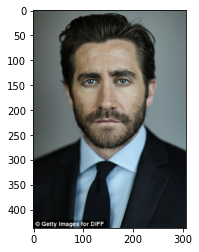

In [ ]:
#to predict new images
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "cloth_mask",
    2: "ffp2_mask",
    3: "surgical_mask"
}

def prepare_predict_df():
    testDatasetPath = 'testDataset' #path to new test data. (not used in training, developement and validation) 
    testDF = pd.DataFrame()

    for img in tqdm(list(testDatasetPath.iterdir()), desc='no'):
        testDF = testDF.append({
            'image': str(img),
            'mask': 0
        }, ignore_index=True)

    for img in tqdm(list(testDatasetPath.iterdir()), desc='cloth'):
        testDF = testDF.append({
            'image': str(img),
            'mask': 1
        }, ignore_index=True)

    for img in tqdm(list(testDatasetPath.iterdir()), desc='ffp2'):
        testDF = testDF.append({
            'image': str(img),
            'mask': 2
        }, ignore_index=True)
        
    for img in tqdm(list(testDatasetPath.iterdir()), desc='surgical'):
        testDF = testDF.append({
            'image': str(img),
            'mask': 3
        }, ignore_index=True)

    return mask_dataset(testDF)

def predict():
    test_df = prepare_predict_df()
    rand_sampler = torch.utils.data.RandomSampler(test_df, num_samples=32, replacement=True)
    data = iter(DataLoader(test_df, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    output = face_mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    rand_ind = random.choice(list(range(0,32)))
    print(data['path'][rand_ind])
    img = Image.open(data['path'][rand_ind])
    plt.imshow(np.asarray(img))
    print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()